In [263]:
import pickle 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

## 加減倉方式

In [455]:
def add_cut_positon(trades, add): #加倉減倉,用原訊號出場
    trades['new_pnl'] = trades['PnL'] 
    trades['new_Return'] = trades['Return']
    trades['add_position'] = 0
    trades['cut_position'] = 0
    trades['add_position_timing'] = 0
    trades['cut_position_timing'] = 0
    trades['avg_price'] = trades['Avg Entry Price']
    eth['open'] = eth['open'].shift(-1)
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit = row['Exit Index']
        entry_price = row['Avg Entry Price']
        exit_price = row['Avg Exit Price']
        data = eth[(eth.index > entry) & (eth.index < exit)]
        if row['Direction']  == 'Long':
            for eth_index, eth_row in data.iterrows():
                if eth_row['close'] / entry_price - 1 > add and trades['add_position'].loc[index] == 0 and trades['cut_position'].loc[index] == 0 :#and signal['long_entry'].loc[eth_index] == True:
                    trades['avg_price'].loc[index] = (eth['open'].loc[eth_index] + trades['avg_price'].loc[index]) / 2
                    trades['new_Return'].loc[index] = (exit_price / trades['avg_price'].loc[index] - 1 - 0.001)
                    trades['add_position'].loc[index] = 1
                    trades['add_position_timing'].loc[index] = eth_index.hour + 1
                    trades['new_pnl'].loc[index] = trades['new_Return'].loc[index] * 200
                if trades['add_position'].loc[index] == 1:
                    break
        else: #short 
            for eth_index, eth_row in data.iterrows():
                if eth_row['close'] / entry_price - 1 < -add and trades['add_position'].loc[index] == 0 and trades['cut_position'].loc[index] == 0 :#and signal['short_entry'].loc[eth_index] == True:
                    trades['avg_price'].loc[index] = (eth['open'].loc[eth_index] + trades['avg_price'].loc[index]) / 2
                    trades['new_Return'].loc[index] = -(exit_price / trades['avg_price'].loc[index] - 1 + 0.001) 
                    trades['add_position'].loc[index] = 1
                    trades['add_position_timing'].loc[index] = eth_index.hour + 1
                    trades['new_pnl'].loc[index] = trades['new_Return'].loc[index] * 200
                if trades['add_position'].loc[index] == 1 and trades['cut_position'].loc[index] == 1:
                    break
                
    add_position_ret = trades.loc[trades['add_position'] == 1, 'new_Return'] - trades.loc[trades['add_position'] == 1, 'Return']
    skewness = trades['PnL'].skew()
    kurtosis = trades['PnL'].kurtosis()
    new_skewness = trades['new_pnl'].skew()
    new_kurtosis = trades['new_pnl'].kurtosis()
    print('勝率: {:.3f}'.format((trades['Return']>0).sum() / len(trades)))
    print('加減倉勝率: {:.3f}'.format((trades['new_Return']>0).sum() / len(trades)))
    print('交易次數: {:.3f}'.format(len(trades)))
    print('加倉次數: {:.3f}'.format((trades['add_position'] != 0).sum()))
    print('加倉前收益: {:.3f}'.format(trades['PnL'].sum()))
    print('加倉後收益: {:.3f}'.format(trades['new_pnl'].sum()))
    print('平均加倉收益: {:.3f}'.format((trades['new_pnl'].sum() - trades['PnL'].sum())/(trades['add_position'] != 0).sum()))
    print('原skewness: {:.3f}'.format(skewness),'後skewness: {:.3f}'.format(new_skewness))
    return trades


In [511]:
def add_positon_by_signal(trades, signal, threshold): #訊號加減倉 #加倉後均價2%止損 #訊號出場沒有固定停利
    trades['new_pnl'] = trades['PnL']
    trades['new_Return'] = trades['Return']
    trades['avg_price'] = 0
    trades['add_position'] = 0
    trades['add_position_timing'] = trades.apply(lambda x: [], axis=1)
    trades['new exit index'] = trades['Exit Index']
    trades['new exit price'] = trades['Avg Entry Price']
    eth['open'] = eth['open'].shift(-1)
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit_index = row['Exit Index']
        entry_price = row['Avg Entry Price']
        avg_price = row['Avg Entry Price']
        data = eth[(eth.index > entry) & (eth.index <= signal.index[-1])]
        if row['Direction']  == 'Long':
            for eth_index, eth_row in data.iterrows():
                if signal['long_entry'].loc[eth_index] == True and trades['add_position'].loc[index] == 0 and eth_row['close'] / entry_price - 1 > threshold:
                    avg_price = (eth['open'].loc[eth_index] + avg_price) / 2
                    trades['add_position'].loc[index] = 1
                    trades['add_position_timing'].loc[index].append(eth_index)
                if trades['add_position'].loc[index] == 1 and (signal['long_exit'].loc[eth_index] == True or (eth_row['close'] / avg_price - 1 - 0.001) < -0.02 or (eth_row['close'] / avg_price - 1 - 0.001) > 0.04):
                    ret = (eth['open'].loc[eth_index] / avg_price - 1 - 0.001)
                    trades['new exit index'].loc[index] = eth_index
                    trades['new exit price'].loc[index] = eth['open'].loc[eth_index]
                    trades['new_pnl'].loc[index] = ret * 200
                    break
                if trades['add_position'].loc[index] == 0 and exit_index == eth_index:
                    ret = row['new_Return']
                    break
        else: #short 
            for eth_index, eth_row in data.iterrows():
                if signal['long_entry'].loc[eth_index] == True and trades['add_position'].loc[index] == 0 and -(eth_row['close'] / entry_price - 1) > threshold:
                    avg_price = (eth['open'].loc[eth_index] + avg_price) / 2
                    trades['add_position'].loc[index] = 1
                    trades['add_position_timing'].loc[index].append(eth_index)
                if trades['add_position'].loc[index] == 1 and (signal['long_exit'].loc[eth_index] == True or -(eth_row['close'] / avg_price - 1 + 0.001) < -0.02 or -(eth_row['close'] / avg_price - 1 + 0.001) > 0.04):
                    ret = -(eth['open'].loc[eth_index] / avg_price - 1 + 0.001)
                    trades['new exit index'].loc[index] = eth_index
                    trades['new exit price'].loc[index] = eth['open'].loc[eth_index]
                    trades['new_pnl'].loc[index] = ret * 200
                    break
                if trades['add_position'].loc[index] == 0 and exit_index == eth_index:
                    ret = row['new_Return']
                    break
        trades['new_Return'].loc[index] = ret
        trades['avg_price'].loc[index] = avg_price

    add_position_ret = trades.loc[trades['add_position'] == 1, 'new_Return'] - trades.loc[trades['add_position'] == 1, 'Return']
    skewness = trades['PnL'].skew()
    kurtosis = trades['PnL'].kurtosis()
    new_skewness = trades['new_pnl'].skew()
    new_kurtosis = trades['new_pnl'].kurtosis()
    print('勝率: {:.3f}'.format((trades['Return']>0).sum() / len(trades)))
    print('加減倉勝率: {:.3f}'.format((trades['new_Return']>0).sum() / len(trades)))
    print('交易次數: {:.3f}'.format(len(trades)))
    print('加倉次數: {:.3f}'.format((trades['add_position'] != 0).sum()))
    print('加倉前收益: {:.3f}'.format(trades['PnL'].sum()))
    print('加倉後收益: {:.3f}'.format(trades['new_pnl'].sum()))
    print('平均加倉收益: {:.3f}'.format((trades['new_pnl'].sum() - trades['PnL'].sum())/(trades['add_position'] != 0).sum()))
    print('原skewness: {:.3f}'.format(skewness),'後skewness: {:.3f}'.format(new_skewness))
    # return trades
    return [trades['new_pnl'].sum(), (trades['new_Return']>0).sum() / len(trades), new_skewness, (trades['new_pnl'].sum() - trades['PnL'].sum())/(trades['add_position'] != 0).sum()]

In [251]:
def add_by_signal_section(trades, signal): #訊號階段
    trades['new_pnl'] = trades['PnL'] 
    trades['new_Return'] = trades['Return']
    trades['avg_price'] = 0 
    trades['add_position'] = 0
    trades['add_position_timing'] = trades.apply(lambda x: [], axis=1)
    trades['new exit index'] = trades['Exit Index']
    trades['new exit price'] = trades['Avg Entry Price']
    eth['open'] = eth['open'].shift(-1)
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit_index = row['Exit Index']
        entry_price = row['Avg Entry Price']
        avg_price = row['Avg Entry Price']
        data = eth[(eth.index > entry) & (eth.index <= signal.index[-1])]
        if row['Direction']  == 'Long':
            for eth_index, eth_row in data.iterrows():
                if signal['long_entry'].loc[eth_index] == True and trades['add_position'].loc[index] == 0 and eth_row['close'] / entry_price - 1 > 0.02:
                    avg_price = (eth['open'].loc[eth_index] + avg_price) / 2
                    trades['add_position'].loc[index] = 1
                    trades['add_position_timing'].loc[index].append(eth_index)
                if signal['long_entry'].loc[eth_index] == True and trades['add_position'].loc[index] == 1 and eth_row['close'] / entry_price - 1 > 0.03:
                    avg_price = (eth['open'].loc[eth_index]/2 + avg_price) / 1.5
                    trades['add_position'].loc[index] = 2
                    trades['add_position_timing'].loc[index].append(eth_index)
                if trades['add_position'].loc[index] != 0 and (signal['long_exit'].loc[eth_index] == True or (eth_row['close'] / avg_price - 1 - 0.001) < -0.02 or (eth_row['close'] / avg_price - 1 - 0.001) > 0.04):
                    ret = (eth['open'].loc[eth_index] / avg_price - 1 - 0.001)
                    trades['new exit index'].loc[index] = eth_index
                    trades['new exit price'].loc[index] = eth['open'].loc[eth_index]
                    if trades['add_position'].loc[index] == 1:
                        trades['new_pnl'].loc[index] = ret * 200
                    else:
                        trades['new_pnl'].loc[index] = ret * 250
                    break
                if trades['add_position'].loc[index] == 0 and exit_index == eth_index:
                    ret = row['new_Return']
                    break
        else: #short 
            for eth_index, eth_row in data.iterrows():
                if signal['long_entry'].loc[eth_index] == True and trades['add_position'].loc[index] == 0 and -(eth_row['close'] / entry_price - 1) > 0.02:
                    avg_price = (eth['open'].loc[eth_index] + avg_price) / 2
                    trades['add_position'].loc[index] = 1
                    trades['add_position_timing'].loc[index].append(eth_index)
                if signal['long_entry'].loc[eth_index] == True and trades['add_position'].loc[index] == 1 and -(eth_row['close'] / entry_price - 1) > 0.03:
                    avg_price = (eth['open'].loc[eth_index]/2 + avg_price) / 1.5
                    trades['add_position'].loc[index] = 2
                    trades['add_position_timing'].loc[index].append(eth_index)
                if trades['add_position'].loc[index] != 0 and (signal['long_exit'].loc[eth_index] == True or -(eth_row['close'] / avg_price - 1 + 0.001) < -0.02 or - (eth_row['close'] / avg_price - 1 + 0.001) > 0.04):
                    ret = -(eth['open'].loc[eth_index] / avg_price - 1 + 0.001)
                    trades['new exit index'].loc[index] = eth_index
                    trades['new exit price'].loc[index] = eth['open'].loc[eth_index]
                    if trades['add_position'].loc[index] == 1:
                        trades['new_pnl'].loc[index] = ret * 200
                    else:
                        trades['new_pnl'].loc[index] = ret * 250
                    break
                if trades['add_position'].loc[index] == 0 and exit_index == eth_index:
                    ret = row['new_Return']
                    break
        trades['new_Return'].loc[index] = ret
        trades['avg_price'].loc[index] = avg_price

    add_position_ret = trades.loc[trades['add_position'] == 1, 'new_Return'] - trades.loc[trades['add_position'] == 1, 'Return']
    skewness = trades['Return'].skew()
    kurtosis = trades['Return'].kurtosis()
    new_skewness = trades['new_Return'].skew()
    new_kurtosis = trades['new_Return'].kurtosis()
    print('勝率: {:.3f}'.format((trades['Return']>0).sum() / len(trades)))
    print('加減倉勝率: {:.3f}'.format((trades['new_Return']>0).sum() / len(trades)))
    print('交易次數: {:.3f}'.format(len(trades)))
    print('加倉次數: {:.3f}'.format((trades['add_position'] != 0).sum()))
    print('加倉前收益: {:.3f}'.format(trades['PnL'].sum()))
    print('加倉後收益: {:.3f}'.format(trades['new_pnl'].sum()))
    print('平均加倉收益: {:.3f}'.format((trades['new_pnl'].sum() - trades['PnL'].sum())/(trades['add_position'] != 0).sum()))
    print('原skewness: {:.3f}'.format(skewness),'後skewness: {:.3f}'.format(new_skewness))

## Other Tools 

In [514]:
def plot_new_ret_dist(trades):  #加減倉過後的
    ret_distribution = (trades['new_pnl']).rename('New PnL')
    q1 = ret_distribution.quantile(0.25)
    q3 = ret_distribution.quantile(0.75)
    mean = ret_distribution.mean()
    median = ret_distribution.median()
    plt.title('Transaction PnL Distribution')
    sns.histplot(ret_distribution, bins=100) # type: ignore
    plt.axvline(x=q1, color='teal', ls='--',
                label="Q1 = {:.2f}%".format(q1))
    plt.axvline(x=q3, color='orange', ls='--',
                label="Q3 = {:.2f}%".format(q3))
    plt.axvline(x=mean, color='red', ls='--',
                label="Mean = {:.2f}%".format(mean))
    plt.axvline(x=median, color='green', ls='--',
                label="Median = {:.2f}%".format(median))
    plt.legend(loc="best")
    plt.show()
    
def new_ret_analysis(trades):
    plt.figure(figsize=(10, 5))
    sns.histplot(trades['PnL'], label='PnL', kde=True)
    sns.histplot(trades['new_pnl'], label='new_PnL', kde=True)
    plt.title('Histogram of PnL and new_PnL')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=trades[['PnL', 'new_pnl']])
    plt.title('Box Plot of PnL and new_pnl')
    plt.show()

def plot_return_mdd(total_return, tag='', axv_index=[]):
    fig, ax = plt.subplots(figsize=(16, 5))
    MDD_series = total_return.cummax()-total_return
    high_index = total_return[total_return.cummax() == total_return].index
    (total_return).plot(label='Total Return', ax=ax, c='r')
    mdd = round(max(MDD_series), 2)
    plt.fill_between(MDD_series.index, -MDD_series,
                        0, facecolor='r', label='DD')
    plt.scatter(
        high_index, total_return.loc[high_index], c='#02ff0f', label='High')
    plt.legend()
    plt.ylabel('Return%')
    plt.xlabel('Date')
    for index in axv_index:
        plt.axvline(index, color='black', zorder=0)

    if tag == '':
        plt.title(f'Return & MDD ({mdd})', fontsize=16)
    else:
        plt.title(f'Return & MDD ({mdd}) - {tag}', fontsize=16)
    plt.show()

def plot_adding_plot(info: dict):  # info: key＝加倉% values=['加倉後return', '加倉後勝率', 'skewness', '平均加倉收益']
    ret = [item[0] for item in info.values()]
    win_rate = [item[1] for item in info.values()]
    skew = [item[2] for item in info.values()]
    ret_per_add = [item[3] for item in info.values()]
    x_positions = range(len(info.keys()))
    x_labels = [str(round(k*100,3))+'%' for k in info.keys()]

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot()
    ax1.bar(x_positions, ret, color='skyblue', label='return',tick_label=x_labels)
    ax1.set_ylabel('return', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(x_positions, win_rate, color='red', label='win_rate')
    ax2.set_ylabel('win_rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # ax3 = ax1.twinx()
    # ax3.plot(x_positions, skew, color='gray', label='skewness')
    # ax3.set_ylabel('skewness', color='gray')
    # ax3.tick_params(axis='y', labelcolor='gray')

    ax4 = ax1.twinx()
    ax4.plot(x_positions, ret_per_add, color='green', label='return_per_adding')
    ax4.set_ylabel('return_per_adding', color='green')
    ax4.tick_params(axis='y', labelcolor='green')

    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(x_labels, rotation=45)
    plt.grid(True)
    plt.show()



In [476]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# trades analysis
def plot_ret_dist(trades):
    ret_distribution = (trades['PnL']).rename('Pnl')
    q1 = ret_distribution.quantile(0.25)
    q3 = ret_distribution.quantile(0.75)
    mean = ret_distribution.mean()
    median = ret_distribution.median()
    plt.title('Transaction PnL Distribution')
    sns.histplot(ret_distribution, bins=100) # type: ignore
    plt.axvline(x=q1, color='teal', ls='--',
                label="Q1 = {:.2f}%".format(q1))
    plt.axvline(x=q3, color='orange', ls='--',
                label="Q3 = {:.2f}%".format(q3))
    plt.axvline(x=mean, color='red', ls='--',
                label="Mean = {:.2f}%".format(mean))
    plt.axvline(x=median, color='green', ls='--',
                label="Median = {:.2f}%".format(median))
    plt.legend(loc="best")
    plt.show();

# trades analysis
def plot_holding_period_dist(trades):
    record = trades
    holding_period = trades['Exit Index']-trades['Entry Index']
    holding_days = holding_period.dt.total_seconds()/86400
    q0 = holding_days.quantile(0)
    q05 = holding_days.quantile(0.05)
    q1 = holding_days.quantile(0.25)
    q2 = holding_days.quantile(0.5)
    q3 = holding_days.quantile(0.75)
    q95 = holding_days.quantile(0.95)
    plt.title('Holding Period Distribution')
    sns.histplot(holding_days.rename('Holding Days'), bins=100) # type: ignore
    plt.axvline(x=q0, color='gray', ls='--')
    plt.axvline(x=q05, ls='--', label="5%   = {:.2f} days".format(q05))
    plt.axvline(x=q1, color='#0343DF', ls='--',
                label="25% = {:.2f} days".format(q1))
    plt.axvline(x=q2, color='teal', ls='--',
                label="50% = {:.2f} days".format(q2))
    plt.axvline(x=q3, color='orange', ls='--',
                label="75% = {:.2f} days".format(q3))
    plt.axvline(x=q95, color='red', ls='--',
                label="95% = {:.2f} days".format(q95))
    plt.legend(loc="best")
    plt.show();
    
# trades analysis
def show_period_analysis(trades,period='Q'):
    trades['Return%'] = trades['Return']*100
    trades = trades[['Entry Index', 'PnL', 'Return%']].fillna(0)
    trades['Profit'] = trades['PnL'].apply(lambda x: x if x > 0 else 0)
    trades['Loss'] = trades['PnL'].apply(lambda x: x if x < 0 else 0)
    trades = trades.set_index('Entry Index')
    trades.index.name = 'datetime'
    temp = trades.resample(period).sum()
    temp['Profit Factor'] = temp['Profit']/temp['Loss'].abs()
    win = trades['PnL'].apply(lambda x: 1 if x < 0 else 0)
    temp['Win Rate%'] = 100 * win.resample(period).sum()/win.resample(period).count()
    temp['Trades'] = win.resample(period).count()
    if period == 'M' or period == 'Q':
        temp.index = temp.index.strftime("%Y-%m")
    elif period == 'Y':
        temp.index = temp.index.strftime("%Y")
    temp = temp.applymap(lambda x: round(x, 2))[['Return%', 'Profit', 'Loss', 'Profit Factor', 'Win Rate%', 'Trades']]
    temp.columns = ['收益率%','毛利','毛損','獲利因子','勝率%','交易次數']
    return temp

def mae_mfe_cal(trades): 
    trades['mae'] = 0
    trades['mfe'] = 0
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit = row['Exit Index']
        price = row['Avg Entry Price']
        min_price = eth['close'].astype(float)[(eth.index <= exit) & (eth.index > entry)].min()
        max_price = eth['close'].astype(float)[(eth.index <= exit) & (eth.index > entry)].max()
        if row['Direction']  == 'Long':
            if min_price > price:
                trades['mae'].loc[index] = 0.001 
            else:
                trades['mae'].loc[index] = (price - min_price) / price
            if max_price < price:
                trades['mfe'].loc[index] = 0.001
            else:
                trades['mfe'].loc[index] = (max_price - price) / price
        else:
            if max_price < price:
                trades['mae'].loc[index] = 0.001 
            else:
                trades['mae'].loc[index] = (max_price - price) / price
            if min_price > price:
                trades['mfe'].loc[index] = 0.001
            else:
                trades['mfe'].loc[index] = (price - min_price) / price
    trades['mfe/mae'] = trades['mfe']/trades['mae']
    return trades

def plot_mae_mfe_dist(trades):
    sns.distplot(trades['mae'])
    plt.title('MAE Distribution')
    plt.xlabel('MAE')
    plt.ylabel('Density')
    plt.show()
    sns.distplot(trades['mfe'])
    plt.title('MFE Distribution')
    plt.xlabel('MFE')
    plt.ylabel('Density')
    plt.show()
    
def bmfe_cal(trades): #計算mae前的最大fe,越大代表可在遇到mae前停利機會越高
    trades['bmfe'] = 0
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit = row['Exit Index']
        price = row['Avg Entry Price']
        mae = trades['mae'].loc[index]
        min_price = eth['close'].astype(float)[(eth.index <= exit) & (eth.index > entry)].min()
        max_price = eth['close'].astype(float)[(eth.index <= exit) & (eth.index > entry)].max()
        if row['Direction']  == 'Long':
            bmfe = 0
            while entry < exit:
                if (eth['close'].loc[entry] != min_price) and ((eth['close'].loc[entry] - price) / price > bmfe):
                    bmfe = (eth['close'].loc[entry] - price) / price
                elif eth['close'].loc[entry] == min_price:
                    break
                entry += pd.Timedelta(minutes=5)
        else:
            while entry < exit:
                if (eth['close'].loc[entry] != min_price) and (eth['close'].loc[entry] < price):
                    bmfe = (price - eth['close'].loc[entry]) / price
                elif eth['close'].loc[entry] == min_price:
                    break
                entry += pd.Timedelta(minutes=5)
        trades['bmfe'].loc[index] = bmfe
    return trades

def mdd_cal(trades):
    trades['mdd'] = 0
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit = row['Exit Index']
        price = row['Avg Entry Price']
        close = eth['close'].astype(float)[(eth.index <= exit) & (eth.index > entry)]
        if row['Direction']  == 'Long':
            mdd = 0
            max_price = close.cummax()
            drawdown = (close - max_price) / max_price
            mdd = drawdown.min()
        else:
            mdd = 0
            min_price = close.cummin()
            drawup = (close - min_price) / min_price
            mdd = drawup.max()
        trades['mdd'].loc[index] = -mdd
    return trades

def mfe_before_mdd(trades):
    trades['mfe_before_mdd'] = 0
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        exit = row['Exit Index']
        price = row['Avg Entry Price']
        close = eth['close'].astype(float)[(eth.index <= exit) & (eth.index > entry)]
        mdd = trades['mdd'].loc[index]
        if row['Direction']  == 'Long':
            bmfe = 0
            max_price = close.cummax()
            drawdown = (close - max_price) / max_price
            mdd = drawdown.min()
            exit = drawdown.loc[drawdown == mdd].index
            exit = exit[-1]
            while entry < exit:
                if (eth['close'].loc[entry] - price) / price > bmfe:
                    bmfe = (eth['close'].loc[entry] - price) / price
                elif eth['close'].loc[entry] == min_price:
                    break
                entry += pd.Timedelta(minutes=5)
        trades['mfe_before_mdd'].loc[index] = bmfe
    trades['mfe/mdd'] = trades['mfe_before_mdd'] / trades['mdd']
    return trades


def pre_volatility(trades):
    trades['volatility'] = 0
    for index, row in trades.iterrows():
        entry = row['Entry Index']
        close = eth['close'].astype(float)[(eth.index <= entry) & (eth.index >= entry - pd.Timedelta(minutes = 60))]
        if row['Direction']  == 'Long':
            volatiltiy =  close.std() 
            trades['volatility'].loc[index] = volatiltiy
    return trades


In [535]:
def hourly_daily_anal(trades): # weekday和hourly收益分析
    trades['day'] = trades['Entry Index'].dt.day_name()
    trades['hour'] = trades['Entry Index'].dt.hour
    sns.boxplot(x='day', y='Return', data=trades, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

    plt.title("Boxplot of Returns by Day of the Week")
    plt.show()

    sns.boxplot(x='hour', y='Return', data=trades, order=range(24))

    plt.title("Boxplot of Returns by Hour of the Day")
    plt.show()


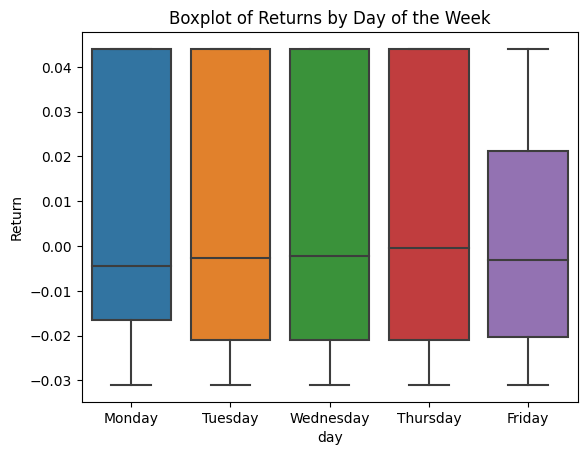

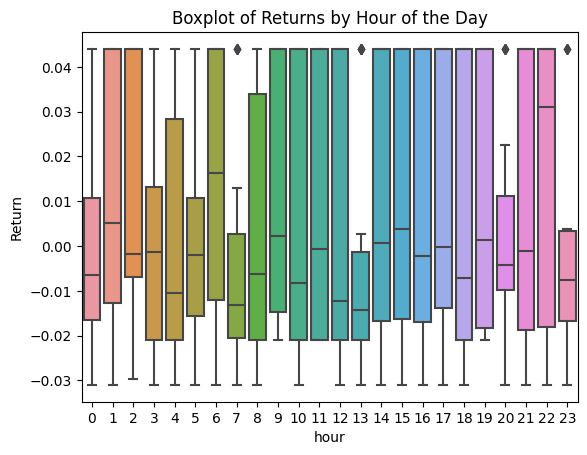

In [536]:
hourly_daily_anal(trades)

## 回測、統計

In [520]:
signal = pd.read_csv('./signal.csv')
signal.set_index('open_time',inplace=True)
signal.index = pd.to_datetime(signal.index)

long = './long_trades.pkl'
short = './short_trades.pkl'
long_f = open(long,'rb')
short_f = open(short,'rb')
long_trades = pickle.load(long_f)
short_trades = pickle.load(short_f)
trades = pd.concat([long_trades, short_trades])
trades = trades.reset_index()
eth = pd.read_hdf('/Volumes/crypto_data/price_data/binance/1m/ETHUSDT_PERPETUAL.h5')
eth = eth.resample('5T').agg({'open': 'first','high':'max','low':'min','close': 'last','volume': 'sum'})

### %加倉

勝率: 0.448
加減倉勝率: 0.396
交易次數: 629.000
加倉次數: 283.000
加倉前收益: 324.556
加倉後收益: 436.524
平均加倉收益: 0.396
原skewness: 0.432 後skewness: 0.470


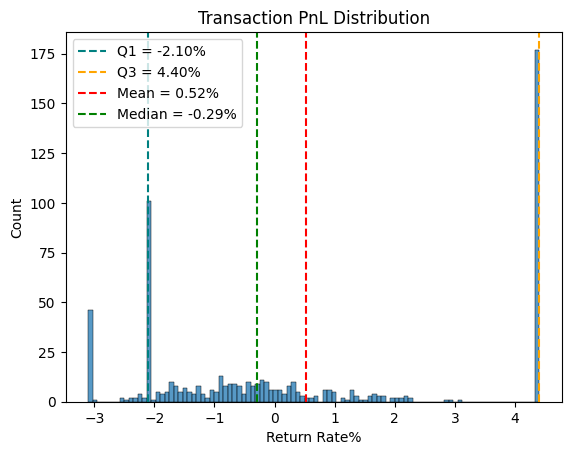

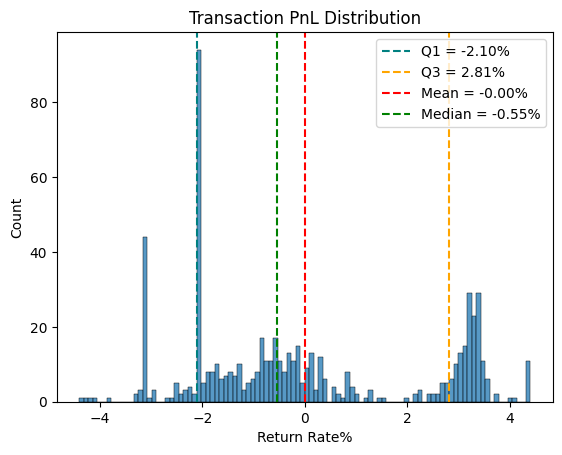

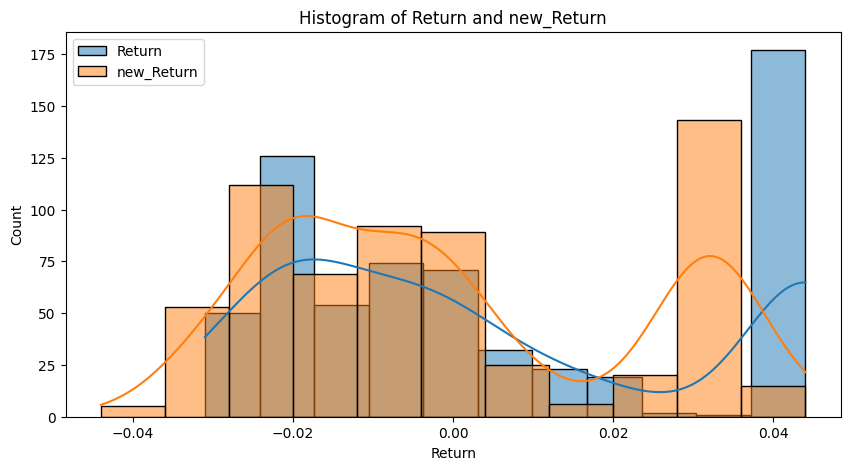

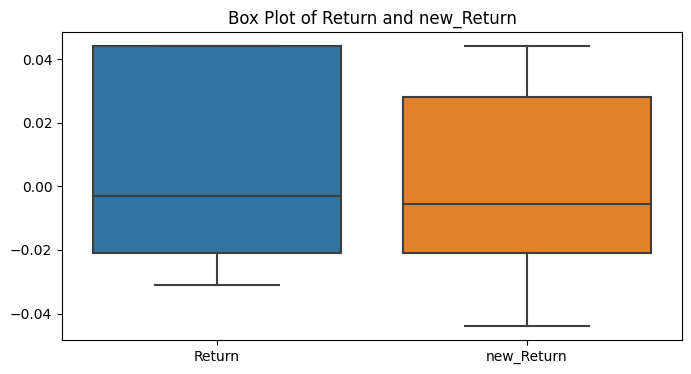

In [465]:
new_trades = add_cut_positon(trades, 0.02, -0.015)
plot_ret_dist(new_trades)
plot_new_ret_dist(new_trades)
new_ret_analysis(new_trades)

### Signal ＋ %

勝率: 0.448
加減倉勝率: 0.424
交易次數: 629.000
加倉次數: 80.000
加倉前收益: 324.556
加倉後收益: 358.823
平均加倉收益: 0.428
原skewness: 0.432 後skewness: 1.152


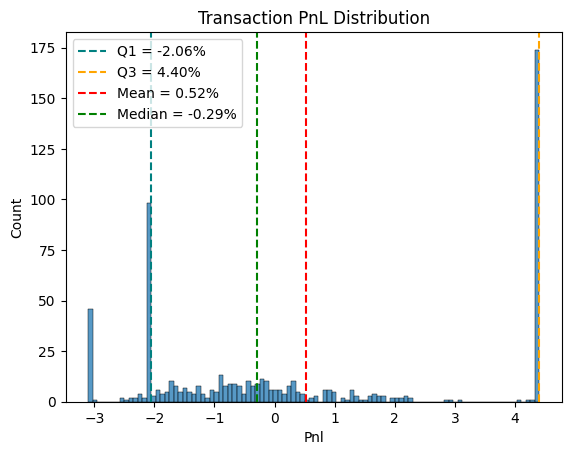

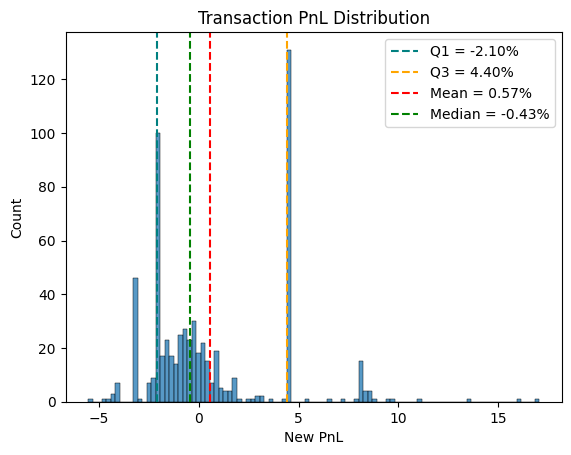

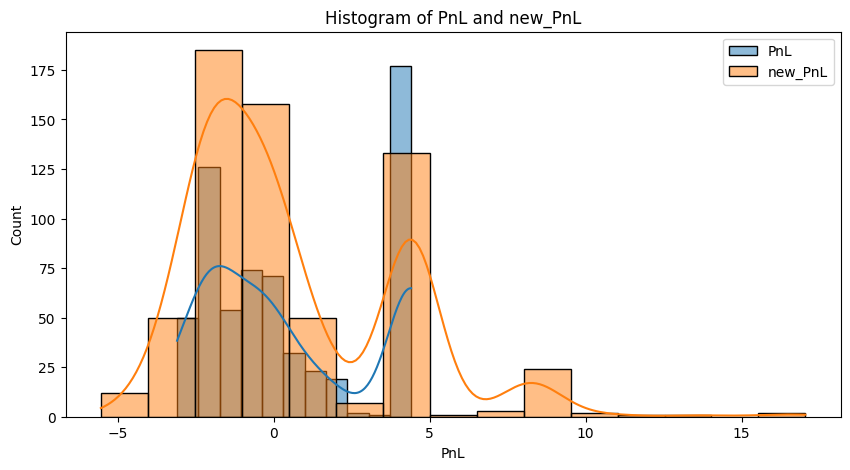

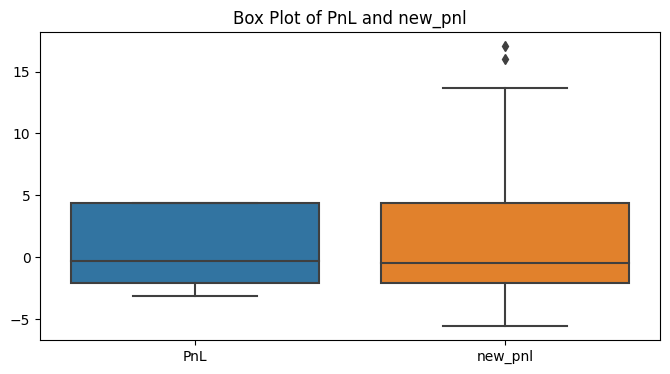

In [506]:
new_trades = add_positon_by_signal(trades, signal, 0.02)
plot_ret_dist(new_trades)
plot_new_ret_dist(new_trades)
new_ret_analysis(new_trades)

In [512]:
threshold = 0.005
info = {}
while threshold <= 0.04:
    eth = pd.read_hdf('/Volumes/crypto_data/price_data/binance/1m/ETHUSDT_PERPETUAL.h5')
    eth = eth.resample('5T').agg({'open': 'first','high':'max','low':'min','close': 'last','volume': 'sum'})
    ret = add_positon_by_signal(trades, signal, threshold)
    info[threshold] = ret
    threshold += 0.001
    
# plot_ret_dist(trades)
# plot_new_ret_dist(trades)
# new_ret_analysis(trades)

勝率: 0.448
加減倉勝率: 0.402
交易次數: 629.000
加倉次數: 211.000
加倉前收益: 324.556
加倉後收益: 333.178
平均加倉收益: 0.041
原skewness: 0.432 後skewness: 0.896
勝率: 0.448
加減倉勝率: 0.401
交易次數: 629.000
加倉次數: 197.000
加倉前收益: 324.556
加倉後收益: 331.997
平均加倉收益: 0.038
原skewness: 0.432 後skewness: 0.916
勝率: 0.448
加減倉勝率: 0.401
交易次數: 629.000
加倉次數: 186.000
加倉前收益: 324.556
加倉後收益: 325.892
平均加倉收益: 0.007
原skewness: 0.432 後skewness: 0.935
勝率: 0.448
加減倉勝率: 0.402
交易次數: 629.000
加倉次數: 169.000
加倉前收益: 324.556
加倉後收益: 358.460
平均加倉收益: 0.201
原skewness: 0.432 後skewness: 0.959
勝率: 0.448
加減倉勝率: 0.405
交易次數: 629.000
加倉次數: 157.000
加倉前收益: 324.556
加倉後收益: 363.390
平均加倉收益: 0.247
原skewness: 0.432 後skewness: 1.004
勝率: 0.448
加減倉勝率: 0.405
交易次數: 629.000
加倉次數: 148.000
加倉前收益: 324.556
加倉後收益: 355.224
平均加倉收益: 0.207
原skewness: 0.432 後skewness: 1.024
勝率: 0.448
加減倉勝率: 0.410
交易次數: 629.000
加倉次數: 139.000
加倉前收益: 324.556
加倉後收益: 368.131
平均加倉收益: 0.313
原skewness: 0.432 後skewness: 1.042
勝率: 0.448
加減倉勝率: 0.415
交易次數: 629.000
加倉次數: 131.000
加倉前收益: 324.556
加倉後收益: 362.827
平均加倉收益: 0.292
原s

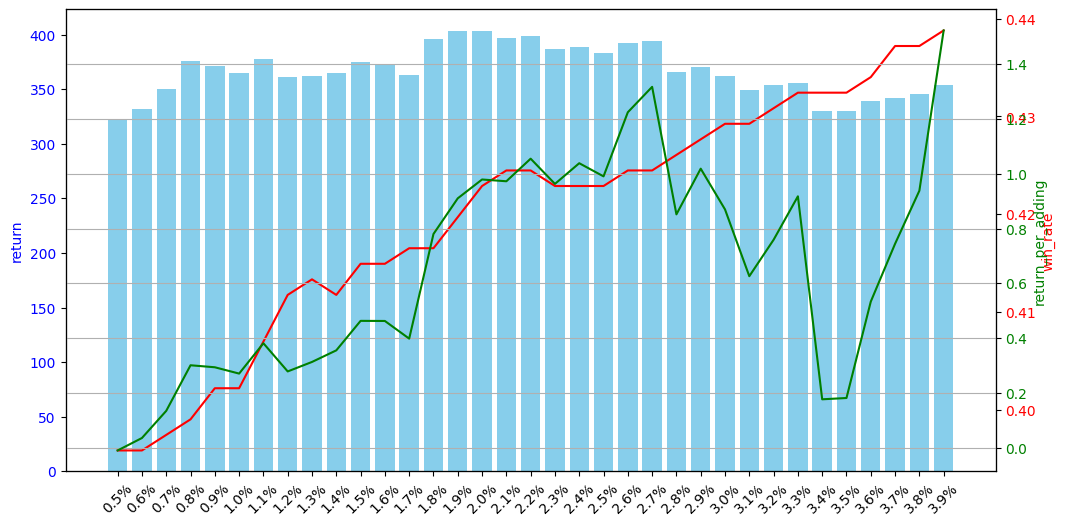

In [ ]:
plot_adding_plot(info) #x%加訊號進場，均價2%停損，訊號出場不停利

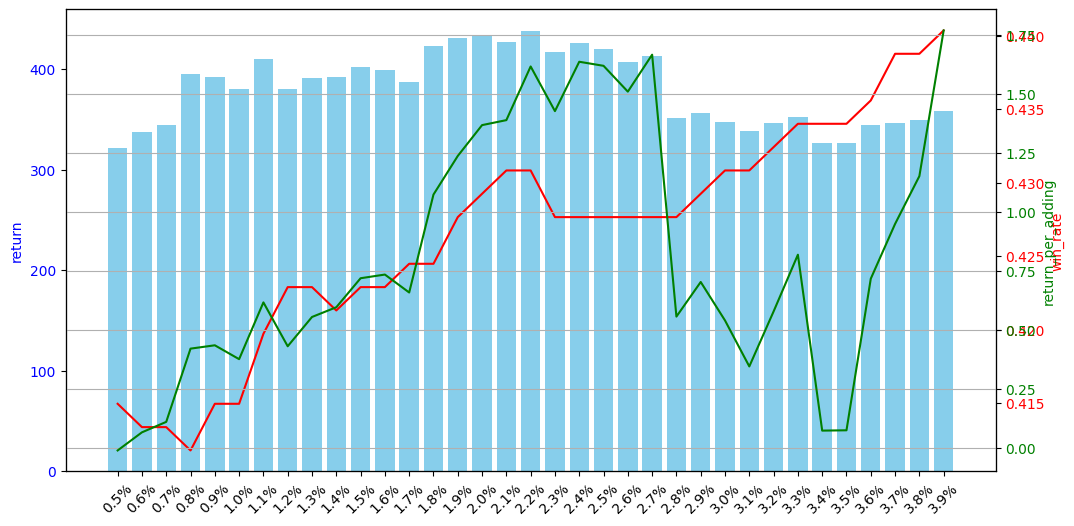

In [498]:
plot_adding_plot(info) #x%加訊號進場，訊號出場不停損停利

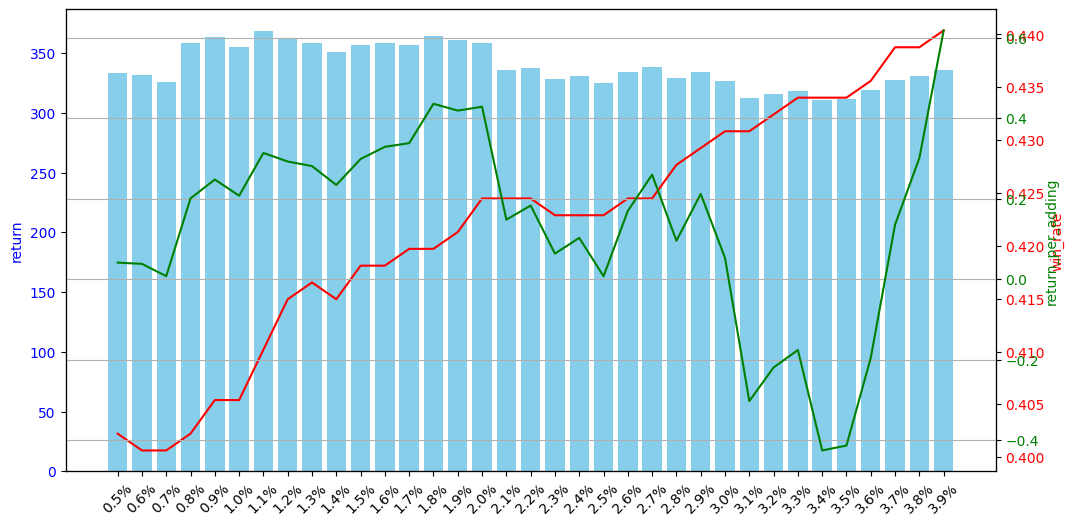

In [513]:
plot_adding_plot(info) #x%加訊號進場，訊號出場，均價2%停損4%停利